# Table of Contents

1. [Pre-Processing and Training Data](#pre-processing-and-training-data)
    1. [Contents](#contents)
    2. [Introduction](#introduction)
    3. [Imports](#imports)
    4. [Load Data](#load-data)
    5. [Extract Data](#extract-data)
    6. [Train/Test Split](#train-test-split)
    7. [Pipelines ARMA (Autoregressive Moving Average)](#pipelines-arma-autoregressive-moving-average)
        1. [Define the pipeline](#define-the-pipeline)
        2. [Fit the pipeline](#fit-the-pipeline)
        3. [Make predictions on the train and test sets](#make-predictions-on-the-train-and-test-sets)
        4. [Assess performance](#assess-performance)
    8. [Pipelines GARCH (Generalized Autoregressive Conditional Heteroskedasticity)](#pipelines-GARCH)

        1. [Define the pipeline](#define-the-pipeline)
        2. [Fit the pipeline](#fit-the-pipeline)
        3. [Make predictions on the train and test sets](#make-predictions-on-the-train-and-test-sets)
        4. [Assess performance](#assess-performance)
    9. [Refining using LSTM (Long Short-Term Memory)](#refining-using-lstm-long-short-term-memory)
        1. [Define the pipeline](#define-the-pipeline-1)
        2. [Fit the pipeline](#fit-the-pipeline-1)
        3. [Assess performance on the train and test set](#assess-performance-on-the-train-and-test-set)
        4. [Define a new pipeline to select a different number of features](#define-a-new-pipeline-to-select-a-different-number-of-features)
        5. [Fit the pipeline](#fit-the-pipeline-2)
        6. [Assess performance on train and test data](#assess-performance-on-train-and-test-data)
        7. [Assessing performance using cross-validation](#assessing-performance-using-cross-validation)
        8. [Hyperparameter search using GridSearchCV](#hyperparameter-search-using-gridsearchcv)
    9. [Moving Average Models](#moving-average-models)
        1. [Define the pipeline](#define-the-pipeline-3)
        2. [Fit and assess performance using cross-validation](#fit-and-assess-performance-using-cross-validation)
        3. [Hyperparameter search using GridSearchCV](#hyperparameter-search-using-gridsearchcv-1)
2. [Final Model Selection](#final-model-selection)
    1. [ARMA model performance](#ARMA-model-performance)
    2. [LSTM model performance](#LSTM-model-performance)
    3. [LSTM model performance](#LSTM-model-performance)
    4. [Conclusion](#conclusion)
    5. [Data quantity assessment](#data-quantity-assessment)


#### 1.1 Importing Libraries<a id='importing_libraries'></a>

In [2]:
import tensorflow as tf
import statsmodels.api as sm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [8]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score  
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from arch import arch_model

# Load the pyplot collection of functions from matplotlib, as plt 
import matplotlib.pyplot as plt # LSTM (Long Short-Term Memory) using TensorFlow


#### 1.2.  Loading the data<a id='1.2_loading_the_data'></a>

The data comes from the [Kaggle](https://www.kaggle.com/datasets/abhimaneukj/tesla-inc-tsla-dataset?resource=download): a free, open-source data-sharing portal with a massive range of datasets.

In [4]:
df = pd.read_csv('../data/TSLA_cleaned.csv')

In [5]:
df.head()

,Date,Open,Open_Delta,High,High_Delta,Low,Low_Delta,Close,Close_Delta,Adj Close,Adj Close_Delta,Volume,Volume_Delta,daily_return Adj Close
0,2010-07-01,5.000,NaN,5.184,NaN,4.054,NaN,4.392,NaN,4.392,NaN,41094000,NaN,NaN
1,2010-07-02,4.600,-0.400,4.620,-0.564,3.742,-0.312,3.840,-0.552,3.840,-0.552,25699000,-15395000.0,-0.125683
2,2010-07-06,4.000,-0.600,4.000,-0.620,3.166,-0.576,3.222,-0.618,3.222,-0.618,34334500,8635500.0,-0.160937
3,2010-07-07,3.280,-0.720,3.326,-0.674,2.996,-0.170,3.160,-0.062,3.160,-0.062,34608500,274000.0,-0.019243
4,2010-07-08,3.228,-0.052,3.504,0.178,3.114,0.118,3.492,0.332,3.492,0.332,38557000,3948500.0,0.105063


#### 1.5  Extract Data<a id='extrat_data'></a>

In [6]:
# Selecting 'Date' and 'Adj Close' columns from df and renaming 'Adj Close' to 'Value'
df1 = df[['Date', 'Adj Close']].rename(columns={'Adj Close': 'value'})

# Displaying the first few rows of df1 to verify the changes
print(df1.head())


         Date  value
0  2010-07-01  4.392
1  2010-07-02  3.840
2  2010-07-06  3.222
3  2010-07-07  3.160
4  2010-07-08  3.492


### 2.0  ARAMA <a id='pipelines-arma-autoregressive-moving-average![image.png](attachment:image.png)'></a>

#### 2.1  Stationary Test <a id='stationary-test![image.png](attachment:image.png)'></a>




* It's important to check if the time series data is stationary or not. The Augmented Dickey-Fuller (ADF) test is commonly used for this purpose.
* The ADF Statistic and p-value help determine stationarity. If the p-value is less than a significance level (e.g., 0.05), we reject the null hypothesis and consider the data stationary.!


In [25]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df1.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.293095
p-value: 0.998951


##### Findings:
* ADF statistic is positive (2.293095), which suggests that the time series is likely non-stationary.
* the p-value is much higher than 0.05 (0.998951), indicating strong evidence against stationarity.

#### 2.2 Autocorrelation and Partial Autocorrelation Analysis:<a id='autocorrelation-and-partial-autocoreelation-analysis'></a>

* Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots are used to identify the correlation between lagged values of a time series.
* These plots help determine the order of differencing needed to make the data stationary and select 

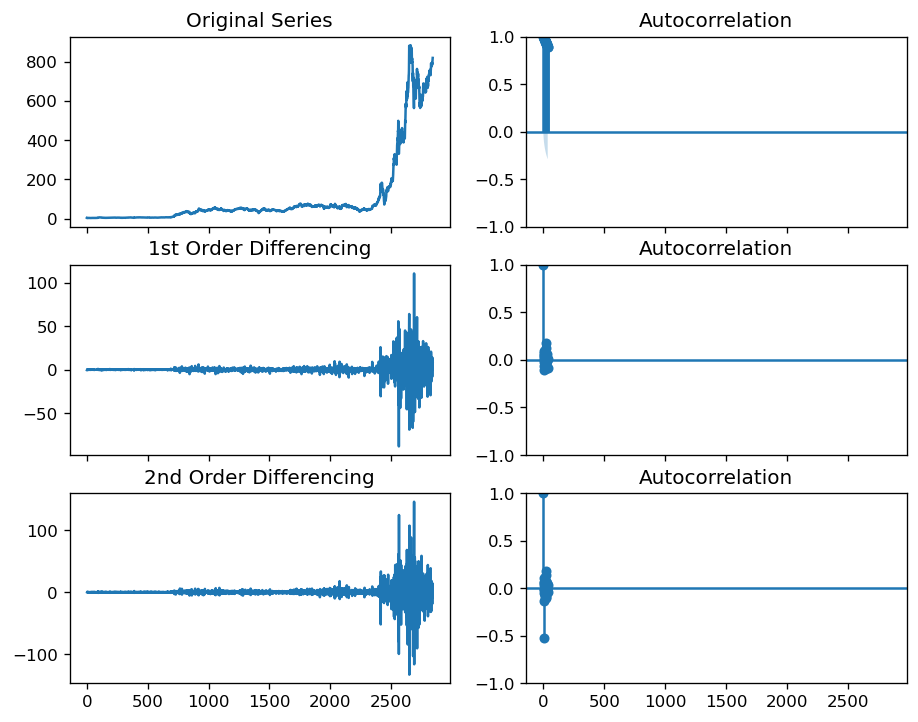

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df1.value); axes[0, 0].set_title('Original Series')
plot_acf(df1.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df1.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df1.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df1.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df1.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()


Autocorrelation (ACF) and partial autocorrelation (PACF) graphs appear compressed and difficult to interpret, with only signals in the first part but nothing interpretable, it may indicate the following:

Insufficient Lag Selection: 
* The signals in the first part of the ACF and PACF plots typically represent autocorrelation at various lag values. If these signals are compressed and not interpretable, it could suggest that you've selected too many or too few lag values. Adjusting the range of lag values might provide clearer insights into the autocorrelation structure of the data.

Non-Stationarity: 
* If the time series data is non-stationary, it can affect the autocorrelation plots. Non-stationarity can lead to erratic behavior in the autocorrelation, making it challenging to interpret the signals. Ensure that you've adequately transformed or differenced the data to achieve stationarity before analyzing the autocorrelation.

Seasonality or Trend: 
* Seasonality or trend in the data can also affect the autocorrelation plots. If the series exhibits strong seasonality or trend, it may dominate the autocorrelation signals, making it difficult to identify other patterns.

High Noise Levels: 
* High levels of noise in the data can obscure meaningful signals in the autocorrelation plots, making them difficult to interpret. Consider smoothing techniques or filtering methods to reduce noise before analyzing autocorrelation.

Data Quality Issues: 
* In some cases, data quality issues such as missing values, outliers, or measurement errors can distort the autocorrelation plots, leading to difficulties in interpretation. Preprocess the data carefully to address any quality issues before analyzing autocorrelation.

#### 1.5  PACF 1st Differenced Series<a id='pacf-1st-differnced-series'></a>

* After observing that the autocorrelation and partial autocorrelation graphs are hard to interpret, focusing on the partial autocorrelation function (PACF) of the first differenced series can provide insights into the potential order of the autoregressive (AR) component in the time series.
* The PACF plot of the first differenced series helps identify significant lags where correlations exist after removing the immediate dependencies.


C:\Users\marti\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


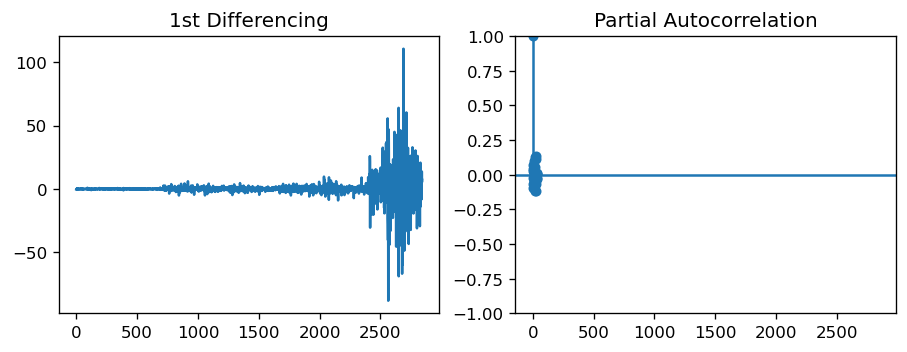

In [27]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df1.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df1.value.diff().dropna(), ax=axes[1])

plt.show()

#### 1.5  ACF 1st Differenced Series<a id='pacf-1st-differnced-series'></a>

*  In addition to the PACF plot, examining the autocorrelation function (ACF) of the first differenced series helps identify significant lags where correlations exist after differencing.
* The ACF plot can provide further insights into the potential order of the moving average (MA) component in the time series.!

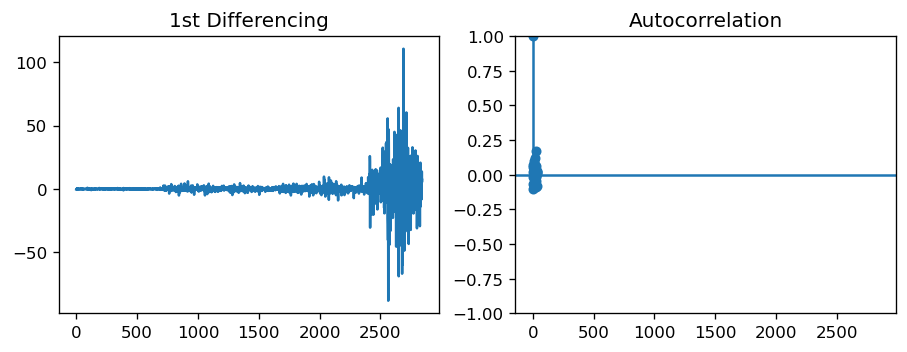

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df1.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df1.value.diff().dropna(), ax=axes[1])

plt.show()

#### 1.5 Fitting ARIMA Model<a id='fitting-arima-model'></a>
* This subsection is crucial as it involves fitting an ARIMA (Autoregressive Integrated Moving Average) model to the time series data.
* The ARIMA model is a powerful tool for time series analysis that combines autoregressive (AR), differencing (I), and moving average (MA) components.



In [29]:

from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df1['value'], order=(1, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 2843
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -9825.407
Date:                Tue, 02 Apr 2024   AIC                          19658.814
Time:                        15:56:28   BIC                          19682.623
Sample:                             0   HQIC                         19667.401
                               - 2843                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3745      0.223     -1.679      0.093      -0.812       0.063
ma.L1          0.3092      0.223      1.389      0.165      -0.127       0.746
ma.L2         -0.0467      0.015     -3.201      0.0

##### Findings: 

###### Model Order:

* The model is specified as ARIMA(1, 1, 2), indicating an autoregressive integrated moving average model of order (p=1, d=1, q=2).
    * This means that the time series has been differenced once to achieve stationarity (d=1), and the model includes one autoregressive term, one moving average term, and an additional moving average term with lag 2.

###### Model Evaluation Metrics:

* The model's log likelihood is -9825.407, and the AIC, BIC, and HQIC values are 19658.814, 19682.623, and 19667.401, respectively.
    * Lower values of AIC, BIC, and HQIC indicate a better fit of the model to the data.

###### Coefficients and Significance Levels:

* The coefficient for the autoregressive term (ar.L1) is -0.3745, and for the moving average terms (ma.L1 and ma.L2) are 0.3092 and -0.0467, respectively.
* The p-values associated with these coefficients are provided, indicating their statistical significance. A p-value less than the significance level (often 0.05) suggests statistical significance.
    * In this case, the autoregressive term and the first moving average term have p-values greater than 0.05, indicating that they may not be statistically significant, while the second moving average term has a p-value less than 0.05, suggesting statistical significance.

###### Residual Diagnostics:
* The Ljung-Box Q-statistic for the first lag (L1) is 0.04, with a p-value of 0.85. This suggests that there is no significant autocorrelation present in the residuals at lag 1.
* The Jarque-Bera test statistic is extremely high at 184579.94, indicating a significant departure from normality in the residuals.
* The Heteroskedasticity test indicates a high value for the H statistic, suggesting the presence of heteroskedasticity in the residuals.

In [30]:
# 1,1,1 ARIMA Model
model = ARIMA(df1['value'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 2843
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9826.284
Date:                Tue, 02 Apr 2024   AIC                          19658.567
Time:                        15:56:28   BIC                          19676.424
Sample:                             0   HQIC                         19665.008
                               - 2843                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0366      0.081      0.452      0.651      -0.122       0.195
ma.L1         -0.1050      0.079     -1.325      0.185      -0.260       0.050
sigma2        58.9787      0.349    168.859      0.0

###### Model Order:
* The model is specified as ARIMA(1, 1, 1), indicating an autoregressive integrated moving average model of order (p=1, d=1, q=1).
    * This means that the time series has been differenced once to achieve stationarity (d=1), and the model includes one autoregressive term and one moving average term.

###### Model Evaluation Metrics:
* The model's log likelihood is -9826.284, and the AIC, BIC, and HQIC values are 19658.567, 19676.424, and 19665.008, respectively.
    * Lower values of AIC, BIC, and HQIC indicate a better fit of the model to the data.

###### Coefficients and Significance Levels:
* The coefficient for the autoregressive term (ar.L1) is 0.0366, and for the moving average term (ma.L1) is -0.1050.
* The p-values associated with these coefficients are provided, indicating their statistical significance. A p-value less than the significance level (often 0.05) suggests statistical significance.
    * In this case, both the autoregressive and moving average terms have p-values greater than 0.05, indicating that they may not be statistically significant.

###### Residual Diagnostics:
* The Ljung-Box Q-statistic for the first lag (L1) is 0.01, with a p-value of 0.94. This suggests that there is no significant autocorrelation present in the residuals at lag 1.
* The Jarque-Bera test statistic is extremely high at 183768.15, indicating a significant departure from normality in the residuals.
* The Heteroskedasticity test indicates a high value for the H statistic, suggesting the presence of heteroskedasticity in the residuals.

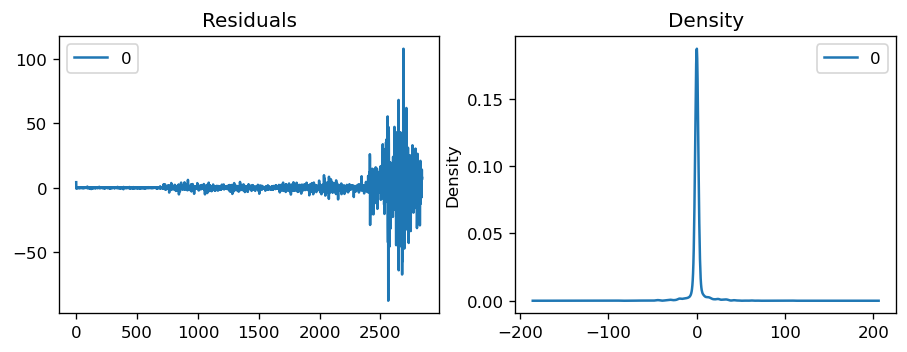

In [31]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

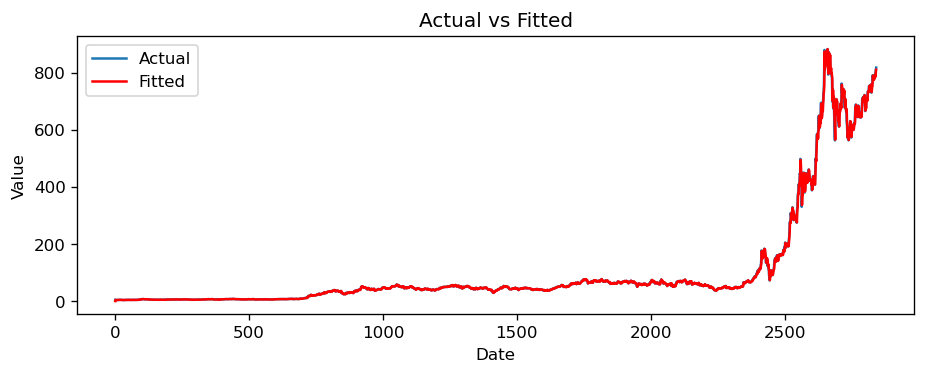

In [32]:
# Actual vs Fitted
plt.plot(df1.index, df1['value'], label='Actual')
plt.plot(df1.index, model_fit.fittedvalues, color='red', label='Fitted')
plt.legend()
plt.title('Actual vs Fitted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


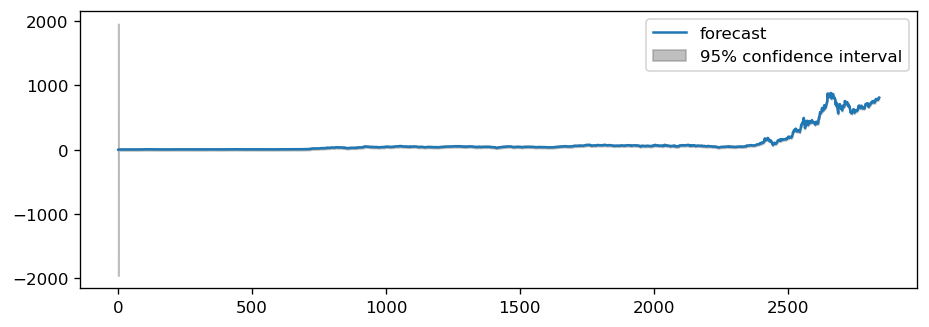

In [33]:
afrom statsmodels.graphics.tsaplots import plot_predict

# Actual vs Fitted
plot_predict(model_fit, dynamic=False)
plt.show()

# GARCH (Generalized Autoregressive Conditional Heteroskedasticity)


###### Capturing Volatility Clustering:

* GARCH models are specifically designed to capture volatility clustering, which is a common characteristic of financial time series where periods of high volatility tend to be followed by periods of high volatility and vice versa. ARIMA models, on the other hand, assume constant variance, which may not adequately capture this phenomenon.

###### Conditional Volatility:

* GARCH models allow the conditional variance of the time series to depend on past values of the series itself, capturing the autoregressive nature of volatility. This can be particularly useful for modeling financial time series where volatility tends to exhibit persistence.

###### Improved Forecasting Accuracy:

* By explicitly modeling the conditional variance of the series, GARCH models can potentially provide more accurate forecasts of future volatility compared to traditional ARIMA models. This is crucial in financial applications where accurate volatility forecasts are essential for risk management, option pricing, and portfolio optimization.

###### Addressing Heteroskedasticity:

* Since GARCH models explicitly model heteroskedasticity, they can effectively address issues related to non-constant variance in the residuals that may be present in the ARIMA model. By capturing the time-varying nature of volatility, GARCH models can produce more reliable estimates of the underlying process.

In [50]:
df['pct_change'] = 100*df['Adj Close'].pct_change()
df.dropna(inplace=True)
df = df.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])

In [60]:
def ts_plot(residuals, stan_residuals, lags=50):
    residuals.plot(title='GARCH Residuals', figsize=(15, 10))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].set_title('GARCH Standardized Residuals KDE')
    ax[1].set_title('GARCH Standardized Residuals Probability Plot')    
    residuals.plot(kind='kde', ax=ax[0])
    probplot(stan_residuals, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(stan_residuals, lags=lags)
    pacf = plot_pacf(stan_residuals, lags=lags)
    acf.suptitle('GARCH Model Standardized Residual Autocorrelation', fontsize=20)
    acf.set_figheight(5)
    acf.set_figwidth(15)
    pacf.set_figheight(5)
    pacf.set_figwidth(15) 
    

In [65]:
from arch import arch_model


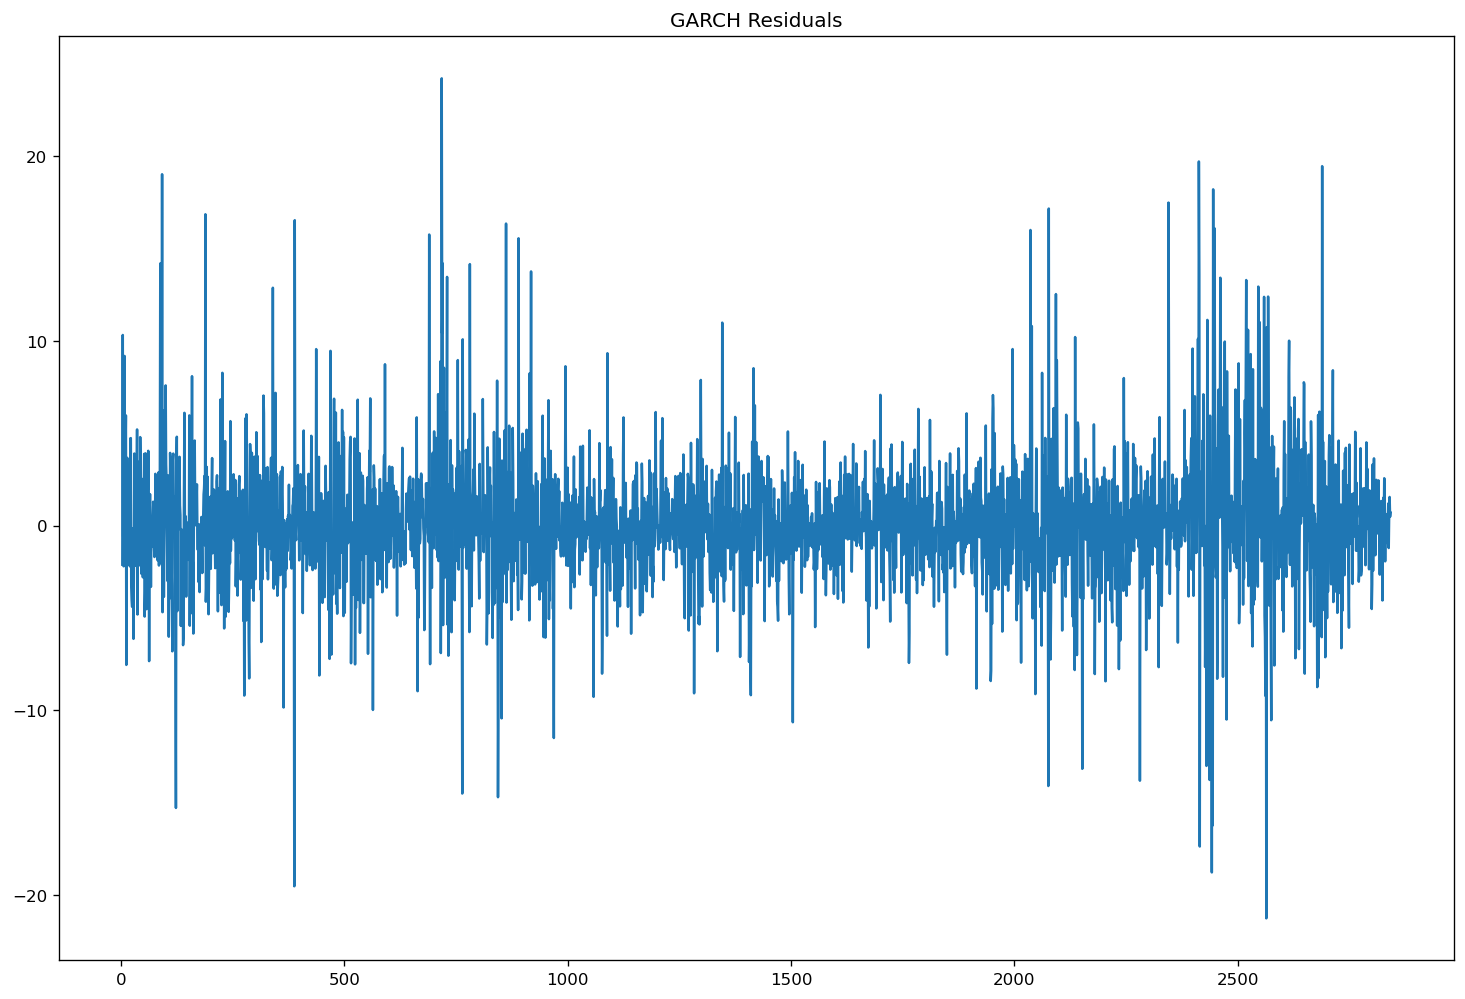

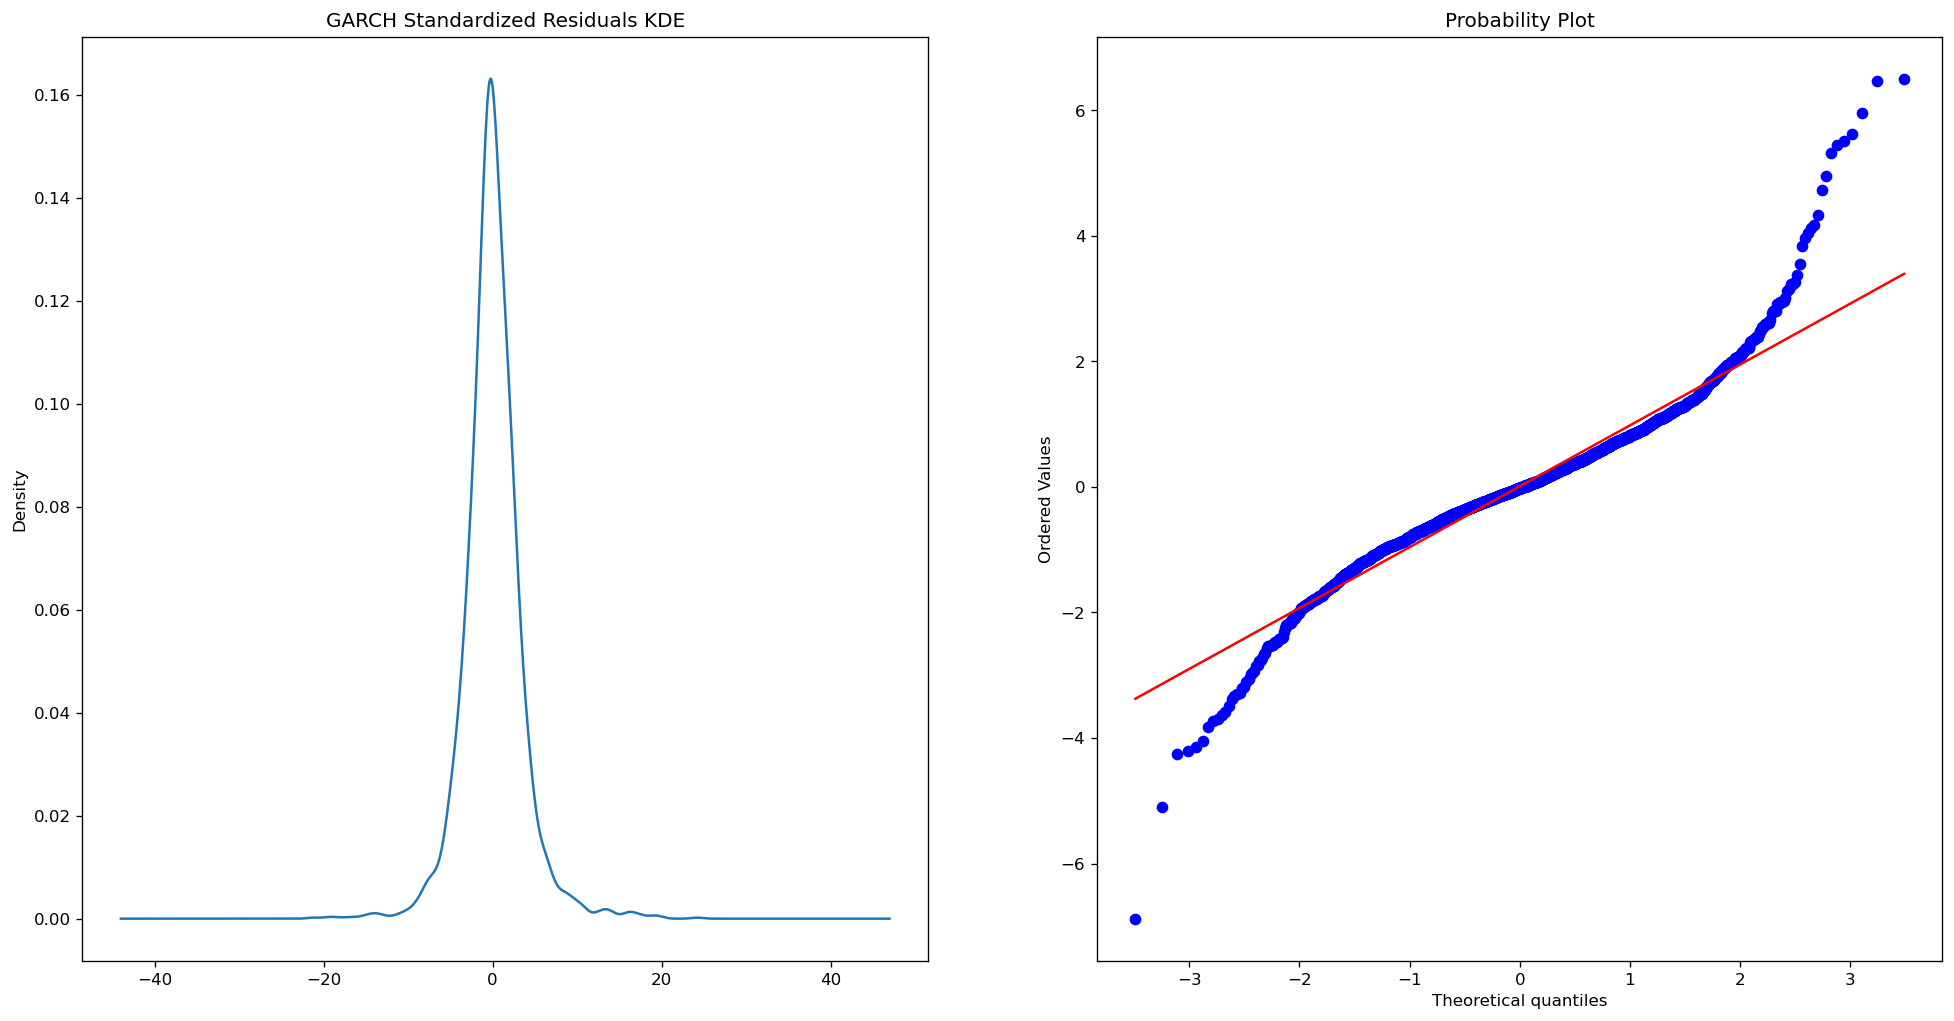

C:\Users\marti\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             pct_change   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7411.80
Distribution:                  Normal   AIC:                           14831.6
Method:            Maximum Likelihood   BIC:                           14855.4
                                        No. Observations:                 2840
Date:                Tue, Apr 02 2024   Df Residuals:                     2839
Time:                        17:55:40   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1847  5.853e-02      3.156  1.600e-03 [7.001e-02,  0.299]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0820  5.035e-02      1.629      0.103  [-1.665e-02,  0.181]
alpha[1]       0.0281  8.947e-03      3.143  1.673e-03 [1.058e-02,4.565e-02]
beta[1]        0.9651  1.177e-02     81.975      0.000     [  0.942,  0.988]
============================================================================

Covariance estimator: robust
"""

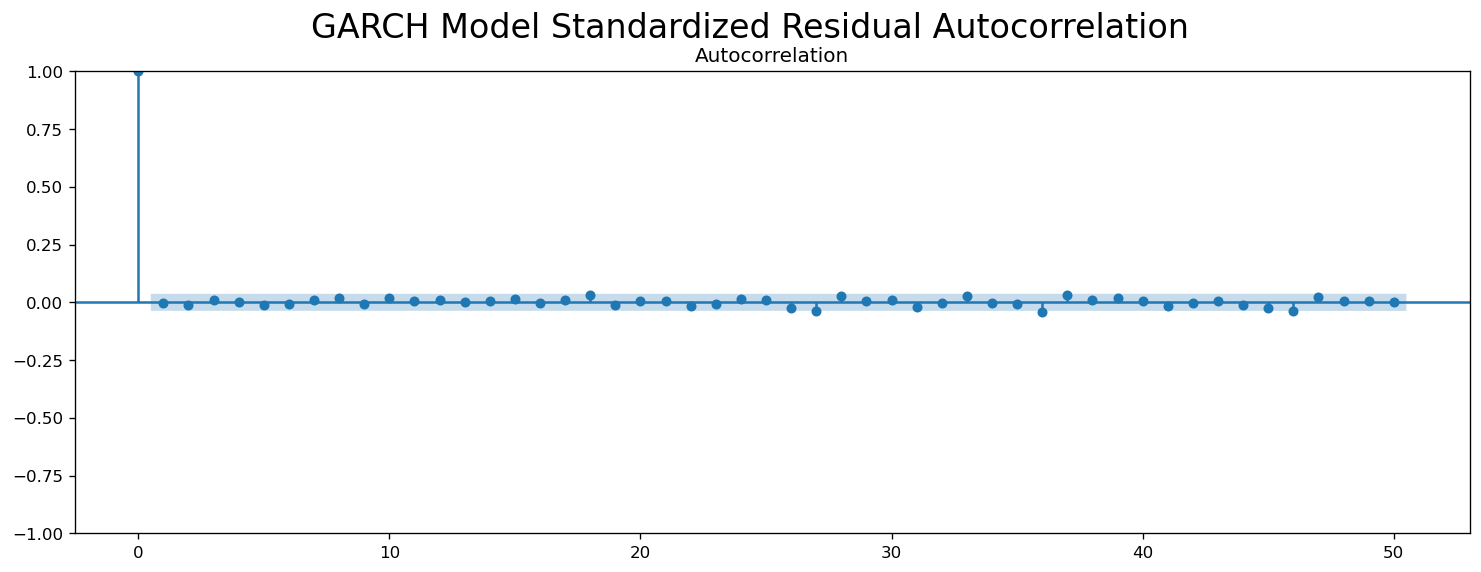

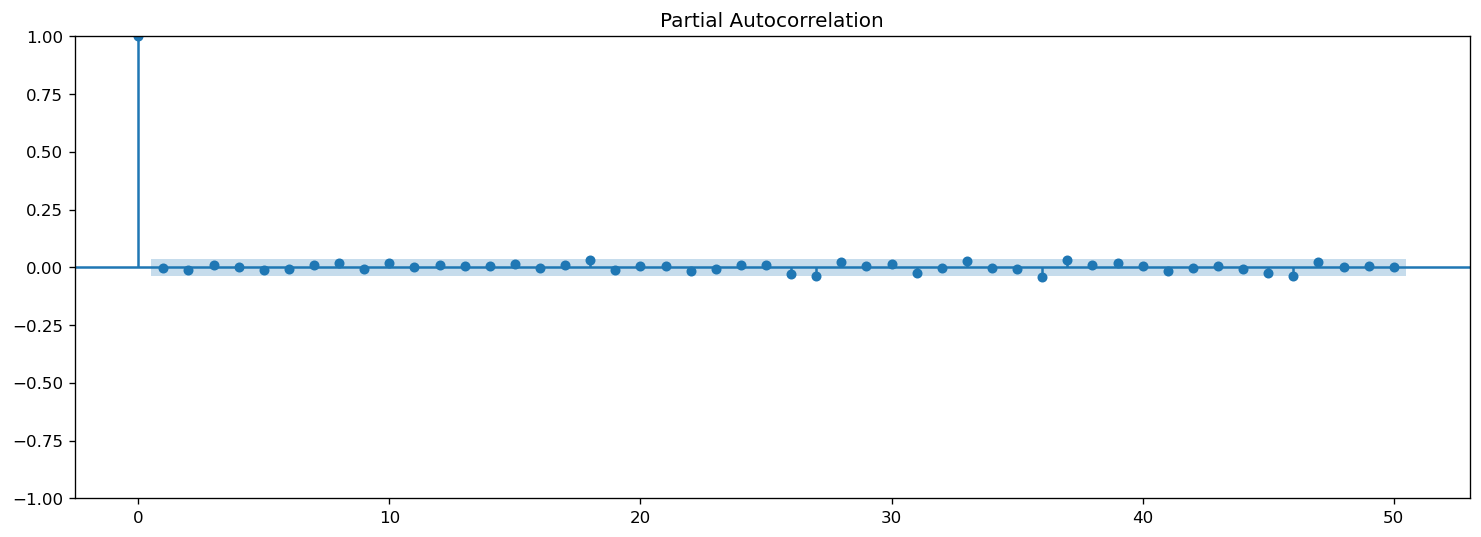

In [66]:
garch = arch_model(df['pct_change'], vol='GARCH', p=1, q=1, dist='normal')
fgarch = garch.fit(disp='off') 
resid = fgarch.resid
st_resid = np.divide(resid, fgarch.conditional_volatility)
ts_plot(resid, st_resid)
fgarch.summary()

In [70]:
from scipy.stats import shapiro


In [71]:
arch_test = het_arch(resid, maxlag=50)
shapiro_test = shapiro(st_resid)

print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')

Lagrange mulitplier p-value: 4.3476220277956063e-26
F test p-value: 1.5878975238121856e-27
Shapiro-Wilks p-value: 2.7448789323162735e-32


C:\Users\marti\AppData\Local\Temp\ipykernel_23168\622623102.py:1: FutureWarning: the 'maxlag'' keyword is deprecated, use 'nlags' instead.
  arch_test = het_arch(resid, maxlag=50)


Here are the results of our GARCH(1,1) model:

Omega is the baseline variance for the model, so the square root of omega is the standard deviation of returns, 60%. This means that with our mean around 0 we can expect our returns to be 0 with a 60% standard deviation, which is very volatile. Autocorrelation in a model can dampen the volatility and cluster low volatility days but this model is capable of producing very large surges.

Next, our alpha and beta coefficients. Alpha measures the extent to which a volatility shock today feeds through into next period’s volatility. In our model 9% of the previous periods volatility will be passed to the next day. Beta is our persistence parameter, if beta is greater than 1 it leads to a positive feedback loop for small shocks that can create runaway volatility. The sum of alpha and beta measures the rate at which our volatility decays and if alpha plus beta equals 1 then our model has persistent volatility and we might want to look at other models like IGARCH (Integrated GARCH).

According to the text, Market Risk Analysis the usual range for alpha in a stable market is 0.05<α<0.1 and the parameter beta is 0.85<β<0.98. These ranges won't totally apply to forecasting a single stock but it gives us an idea of what kinds of values we should be seeing.

Next, we have our t-statistics and p-values. T is our estimate divided by the standard error and is used to calculate our p-value. The usual null hypothesis is that our coefficient has no effect but we can reject the null if our p value is less than an alpha (0.05). When we begin having models with more parameters it can be helpful to pay attention to the p-values.

Above we have run some tests for goodness of fit that we'll introduce below. All of the tests indicate we should reject the null so we'll continue to search for better model parameters. We can see there is clearly autocorrelation out to at least the 25th lag, and the standardized residuals do not look like white noise. We'll use a grid search with fairly large range of p and q to find a model that best fits the volatility.

Model Fit

To measure how well our ARCH/GARCH model fit our data we want to check for:

Autocorrelation in the standardized residuals, we can again use the Ljung-Box test.
ARCH effects(conditional heteroskedasticity) in the residuals, we will use Engle's ARCH test on the residuals.
Normal distribution in the standardized residuals, we can use the Shapiro-Wilk test, Q-Q plot, and if larger n- the Jarque-Bera test to see if our data approaches normality.

Engle's ARCH Test
Ho: The squared residuals are a sequence of white noise- the residuals are homoskedastic.
Ha: The squared residuals could not be fitted with a linear regression model and exhibit heteroskedasticity.

In Python, we will be using the ARCH Engle's test which is a combination of Ljung-Box and a Lagrange Multiplier test to determine if our ARCH model has captured the conditional heteroskedasticity of our time series. We will pass it the array of residuals and a max lag to use.

Shapiro-Wilks Test
The Shapiro-Wilks test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution.

Ho: The data is normally distributed
Ha: The data is not normally distributed

Jarque-Bera Test
The Jarque-Bera test is a type of Lagrange Multiplier test for normality. It usually used for large data sets because other normality tests are not reliable when n is large, Shapiro-Wilk isn't reliable with n more than 2,000. Jarque-Bera specifically matches skewness and kurtosis to a normal distribution.

Ho: The data is normally distributed
Ha: The data does not come from a normal distributio

In [72]:
def gridsearch(data, p_rng, q_rng):
    top_score, top_results = float('inf'), None
    top_models = []
    for p in p_rng:
        for q in q_rng:
            try:
                model = arch_model(data, vol='GARCH', p=p, q=q, dist='normal')
                model_fit = model.fit(disp='off')
                resid = model_fit.resid
                st_resid = np.divide(resid, model_fit.conditional_volatility)
                results = evaluate_model(resid, st_resid)
                results['AIC'] = model_fit.aic
                results['params']['p'] = p
                results['params']['q'] = q
                if results['AIC'] < top_score: 
                    top_score = results['AIC']
                    top_results = results
                elif results['LM_pvalue'][1] is False:
                    top_models.append(results)
            except:
                continue
    top_models.append(top_results)
    return top_models
                
def evaluate_model(residuals, st_residuals, lags=50):
    results = {
        'LM_pvalue': None,
        'F_pvalue': None,
        'SW_pvalue': None,
        'AIC': None,
        'params': {'p': None, 'q': None}
    }
    arch_test = het_arch(residuals, maxlag=lags)
    shap_test = shapiro(st_residuals)
    # We want falsey values for each of these hypothesis tests
    results['LM_pvalue'] = [arch_test[1], arch_test[1] < .05]
    results['F_pvalue'] = [arch_test[3], arch_test[3] < .05]
    results['SW_pvalue'] = [shap_test[1], shap_test[1] < .05]
    return results

In [73]:
p_rng = range(0,30)
q_rng = range(0,40)
df['dif_pct_change'] = df['pct_change'].diff()
top_models = gridsearch(df['dif_pct_change'], p_rng, q_rng)
print(top_models)

[None]


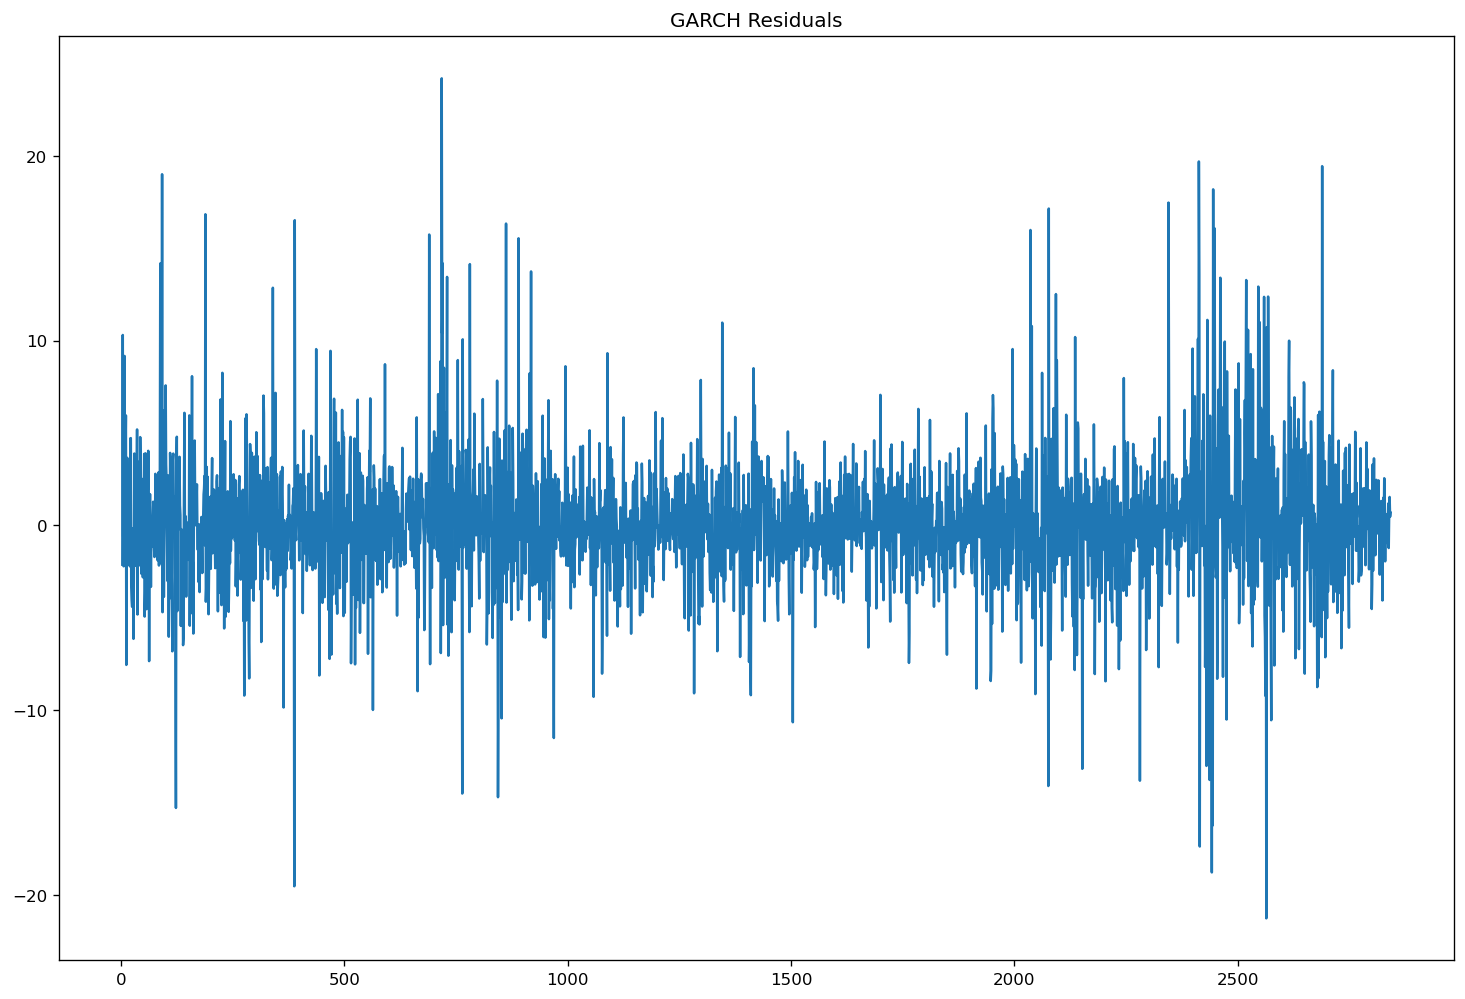

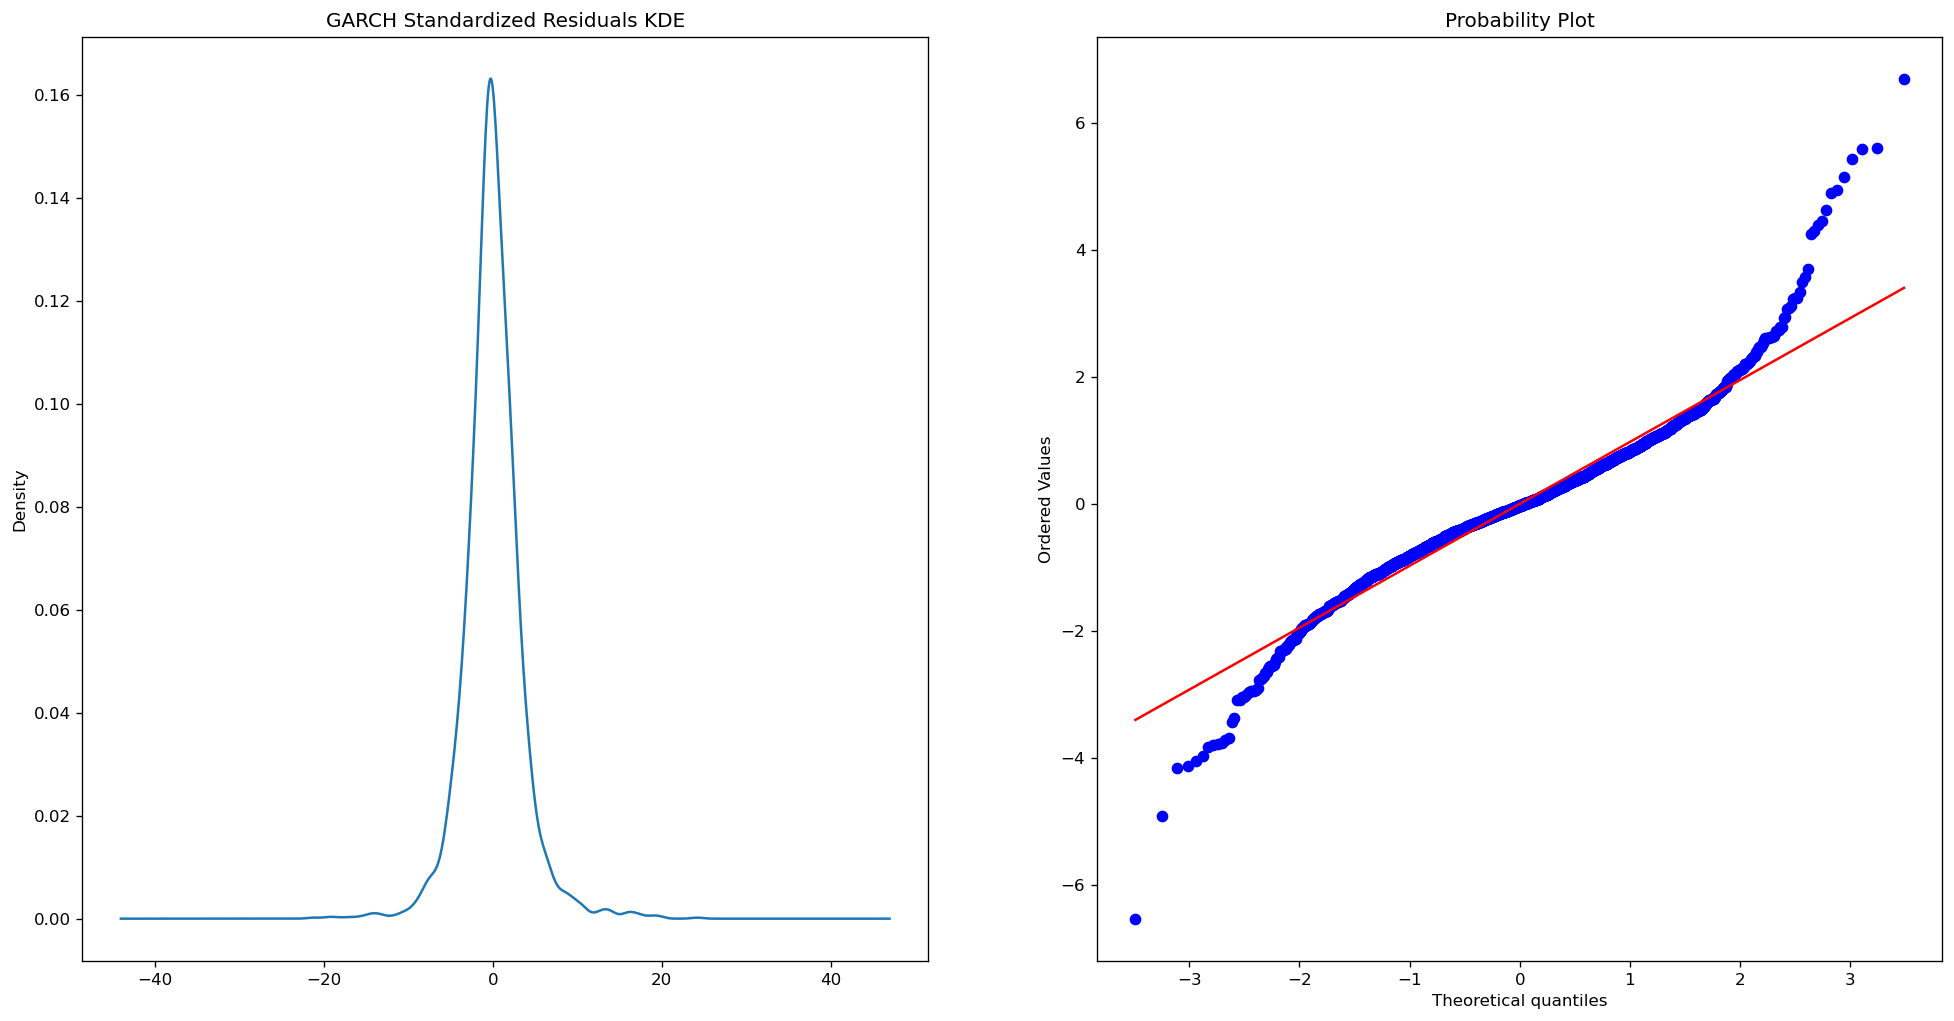

C:\Users\marti\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\marti\AppData\Local\Temp\ipykernel_23168\3993344148.py:6: FutureWarning: the 'maxlag'' keyword is deprecated, use 'nlags' instead.
  arch_test = het_arch(resid, maxlag=50)


Lagrange mulitplier p-value: 4.1515187516987497e-26
F test p-value: 1.5099132629952405e-27
Shapiro-Wilks p-value: 1.148160815781487e-29


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             pct_change   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7363.79
Distribution:                  Normal   AIC:                           14815.6
Method:            Maximum Likelihood   BIC:                           15077.4
                                        No. Observations:                 2840
Date:                Tue, Apr 02 2024   Df Residuals:                     2839
Time:                        18:18:36   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1995      0.115      1.728  8.400e-02 [-2.678e-02,  0.426]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.9427      3.062      0.308      0.758    [ -5.059,  6.944]
alpha[1]       0.0716  6.756e-02      1.060      0.289 [-6.080e-02,  0.204]
alpha[2]       0.0971      0.383      0.254      0.800    [ -0.654,  0.848]
alpha[3]       0.0607      0.173      0.352      0.725    [ -0.278,  0.399]
alpha[4]       0.0332      0.309      0.107      0.914    [ -0.572,  0.638]
alpha[5]   2.4352e-09      0.659  3.694e-09      1.000    [ -1.292,  1.292]
alpha[6]       0.0000      0.669      0.000      1.000    [ -1.311,  1.311]
alpha[7]       0.0109      0.249  4.370e-02      0.965    [ -0.478,  0.500]
alpha[8]       0.0235      0.345  6.827e-02      0.946    [ -0.652,  0.699]
alpha[9]       0.0000      0.404      0.000      1.000    [ -0.792,  0.792]
alpha[10]      0.0000      0.357      0.000      1.000    [ -0.699,  0.699]
alpha[11]      0.0297      0.692  4.294e-02      0.966    [ -1.327,  1.386]
alpha[12]      0.0161      0.235  6.833e-02      0.946    [ -0.445,  0.478]
alpha[13]  1.5564e-10  5.744e-02  2.709e-09      1.000    [ -0.113,  0.113]
alpha[14]      0.0000  7.188e-02      0.000      1.000    [ -0.141,  0.141]
alpha[15]      0.0465  9.273e-02      0.501      0.616    [ -0.135,  0.228]
alpha[16]      0.0000      0.119      0.000      1.000    [ -0.233,  0.233]
alpha[17]  2.3127e-04      0.132  1.758e-03      0.999    [ -0.258,  0.258]
beta[1]        0.0000      2.170      0.000      1.000    [ -4.253,  4.253]
beta[2]        0.0000      1.581      0.000      1.000    [ -3.098,  3.098]
beta[3]    4.4744e-10      3.239  1.381e-10      1.000    [ -6.349,  6.349]
beta[4]        0.0000      2.475      0.000      1.000    [ -4.852,  4.852]
beta[5]        0.0000      0.338      0.000      1.000    [ -0.662,  0.662]
beta[6]        0.0000      1.425      0.000      1.000    [ -2.792,  2.792]
beta[7]        0.0000      1.608      0.000      1.000    [ -3.152,  3.152]
beta[8]        0.0000      0.601      0.000      1.000    [ -1.178,  1.178]
beta[9]        0.0000      3.284      0.000      1.000    [ -6.437,  6.437]
beta[10]       0.0000      1.539      0.000      1.000    [ -3.016,  3.016]
beta[11]       0.0000      0.417      0.000      1.000    [ -0.816,  0.816]
beta[12]       0.0000      1.730      0.000      1.000    [ -3.391,  3.391]
beta[13]       0.0148      1.370  1.080e-02      0.991    [ -2.670,  2.699]
beta[14]   3.4271e-11      0.400  8.575e-11      1.000    [ -0.783,  0.783]
beta[15]       0.0000      0.599      0.000   

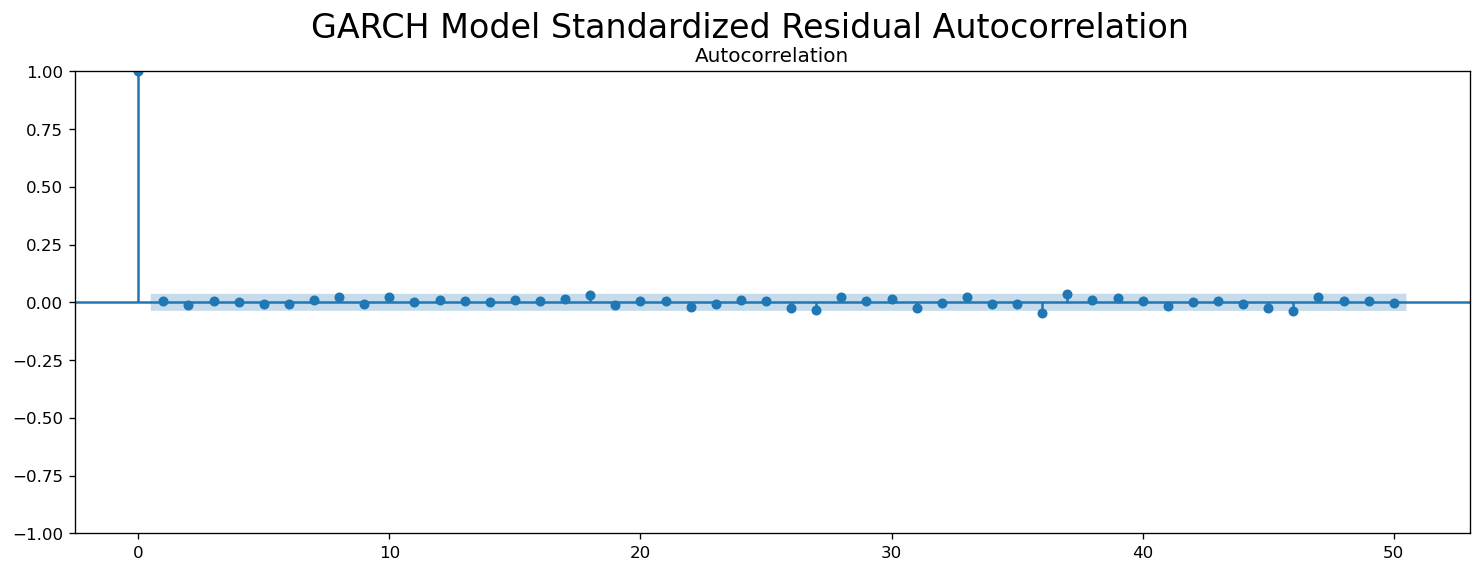

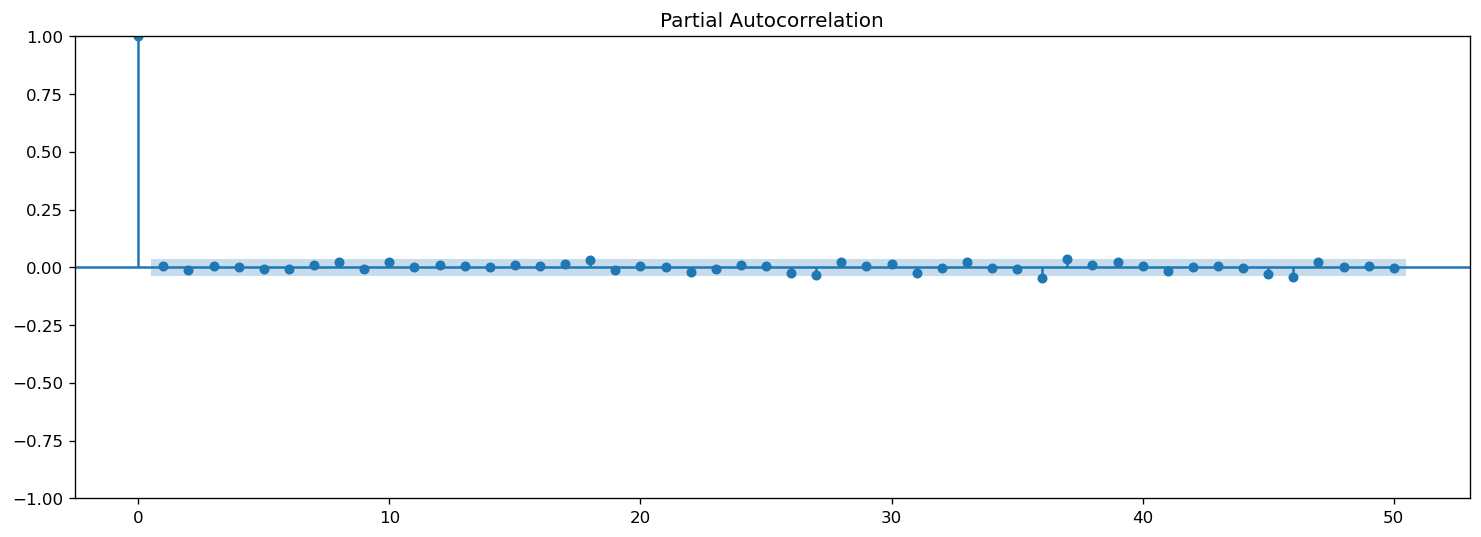

In [74]:
garch = arch_model(df['pct_change'], vol='GARCH', p=17, q=25, dist='normal')
fgarch = garch.fit(disp='off') 
resid = fgarch.resid
st_resid = np.divide(resid, fgarch.conditional_volatility)
ts_plot(resid, st_resid)
arch_test = het_arch(resid, maxlag=50)
shapiro_test = shapiro(st_resid)
print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')
fgarch.summary()

Findings:
###### Mean Model Analysis:
* The constant mean model suggests that the mean of the percentage change in the asset's value is estimated to be 0.1847, with a standard error of 5.853e-02. The t-statistic for this coefficient is 3.156, indicating statistical significance at the 0.05 level.
    * This finding implies that there is a significant mean effect in the data, indicating that the asset's returns exhibit some level of average behavior over time.
###### Volatility Model Analysis:
* The GARCH volatility model estimates the parameters for volatility dynamics. The parameter alpha[1] is estimated to be 0.0281, with a standard error of 8.947e-03 and a t-statistic of 3.143, suggesting statistical significance at the 0.05 level.
    * This parameter represents the short-term impact of past squared errors on the current volatility.
* The parameter beta[1], representing the long-term impact of past squared volatility on current volatility, is estimated to be 0.9651, with a very high t-statistic of 81.975, indicating strong statistical significance.
    * This finding suggests that past volatility strongly influences current volatility, indicating a persistence in volatility clustering.
###### Model Fit and Distribution:
* The log-likelihood of the GARCH model is -7411.80, and the AIC and BIC values are 14831.6 and 14855.4, respectively. These metrics provide measures of the model's goodness of fit and complexity.
    * The negative log-likelihood indicates that the model fits the data better than a model with no parameters. 
    The AIC and BIC values help compare the model's fit relative to its complexity, with lower values indicating better fit. 
        * These values suggest that the GARCH model provides a reasonable fit to the data.


C:\Users\marti\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.565e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 84487.40501721106
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1037269.0801420356
Iteration:      3,   Func. Count:     18,   Neg. LLF: 15096.709992412372
Iteration:      4,   Func. Count:     24,   Neg. LLF: 17175.074727823892
Iteration:      5,   Func. Count:     30,   Neg. LLF: 92421.5237334079
Iteration:      6,   Func. Count:     36,   Neg. LLF: 14242.300447108577
Iteration:      7,   Func. Count:     41,   Neg. LLF: 14229.660436497918
Iteration:      8,   Func. Count:     46,   Neg. LLF: 14226.594210471823
Iteration:      9,   Func. Count:     51,   Neg. LLF: 14225.628561902324
Iteration:     10,   Func. Count:     56,   Neg. LLF: 14220.413909996249
Iteration:     11,   Func. Count:     61,   Neg. LLF: 14193.605575400925
Iteration:     12,   Func. Count:     66,   Neg. LLF: 14039.493200956178
Iteration:     13,   Func. Count:     71,   Neg. LLF: 14035.692588022128
Iteration:     14,   Func. Count:     77,   Neg. LLF: 

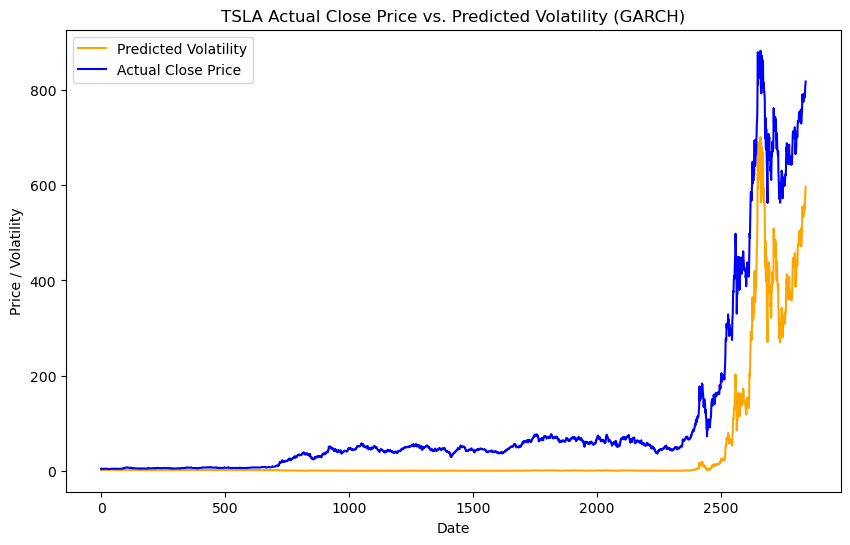

In [11]:
# Create a GARCH model
model = arch_model(df1['value'], vol='Garch', p=1, q=1)
results = model.fit()

# Generate volatility predictions
forecasts = results.forecast(start=0)

# Plot actual data and predicted volatility
plt.figure(figsize=(10, 6))
plt.plot(forecasts.variance.index, forecasts.variance/10**3, label='Predicted Volatility', color='orange')
plt.plot(df1.index, df1['value'], label='Actual Close Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Price / Volatility')
plt.title('TSLA Actual Close Price vs. Predicted Volatility (GARCH)')
plt.legend()
plt.show()



In [14]:
df1.head()

,value,value_rescaled
Date,,
2010-07-01,4.392,0.4392
2010-07-02,3.840,0.3840
2010-07-06,3.222,0.3222
2010-07-07,3.160,0.3160
2010-07-08,3.492,0.3492


d

In [20]:
df2 = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
df.head()

,Date,Open,Open_Delta,High,High_Delta,Low,Low_Delta,Close,Close_Delta,Adj Close,Adj Close_Delta,Volume,Volume_Delta,daily_return Adj Close
0,2010-07-01,5.000,NaN,5.184,NaN,4.054,NaN,4.392,NaN,4.392,NaN,41094000,NaN,NaN
1,2010-07-02,4.600,-0.400,4.620,-0.564,3.742,-0.312,3.840,-0.552,3.840,-0.552,25699000,-15395000.0,-0.125683
2,2010-07-06,4.000,-0.600,4.000,-0.620,3.166,-0.576,3.222,-0.618,3.222,-0.618,34334500,8635500.0,-0.160937
3,2010-07-07,3.280,-0.720,3.326,-0.674,2.996,-0.170,3.160,-0.062,3.160,-0.062,34608500,274000.0,-0.019243
4,2010-07-08,3.228,-0.052,3.504,0.178,3.114,0.118,3.492,0.332,3.492,0.332,38557000,3948500.0,0.105063


In [ ]:
# Create a new dataframe with only the 'Close' column
c = df2.filter(['Close'])

# Convert the dataframe to a numpy array
d = c.values

# Get the number of rows to train the model on
l = int(np.ceil(len(d) * .95))

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(d)

In [23]:
# Extracting training data from scaled_data up to training_data_len
train_data = scaled_data[0:int(l), :]

# Initialize lists for input and output sequences
x_train = []
y_train = []

# Create input and output sequences
for i in range(60, len(train_data)):
    # Append the last 60 values to x_train and the next value to y_train
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
    # Print for the first two iterations to check
    if i <= 61:
        print(x_train)
        print(y_train)
        print()

# Convert lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train data for compatibility with LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


[array([1.40011133e-03, 7.72788721e-04, 7.04601481e-05, 0.00000000e+00,
       3.77302728e-04, 3.63665280e-04, 2.84113500e-04, 5.31860473e-04,
       9.18254833e-04, 9.29619373e-04, 1.10008747e-03, 1.38874679e-03,
       1.02280860e-03, 1.00462534e-03, 1.18191216e-03, 1.24782649e-03,
       1.17054762e-03, 1.07963130e-03, 1.11827074e-03, 1.03417314e-03,
       9.40983913e-04, 1.16372890e-03, 1.39783842e-03, 1.24100777e-03,
       1.05690222e-03, 8.61432133e-04, 8.63705041e-04, 7.34149285e-04,
       4.77310681e-04, 4.09123440e-04, 5.72772817e-04, 6.77326585e-04,
       7.61424181e-04, 6.75053677e-04, 6.79599493e-04, 7.50059641e-04,
       9.84169165e-04, 7.72788721e-04, 9.31892281e-04, 8.97798661e-04,
       8.86434121e-04, 9.25073557e-04, 8.36430145e-04, 1.05690222e-03,
       1.19554961e-03, 1.19327670e-03, 1.07735839e-03, 1.15918308e-03,
       1.11599783e-03, 9.93260797e-04, 1.11827074e-03, 1.20918706e-03,
       1.40465715e-03, 1.16827471e-03, 1.00689825e-03, 1.19554961e-03,
     

In [24]:
# Define the sequential model
model = Sequential()

# Add the first LSTM layer with 128 units and return sequences
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))

# Add the second LSTM layer with 64 units and don't return sequences
model.add(LSTM(64, return_sequences=False))

# Add a dense layer with 32 units
model.add(Dense(32))

# Add another dense layer with 16 units
model.add(Dense(16))

# Add the output layer with 1 unit
model.add(Dense(1))



C:\Users\marti\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks directly in the fit method
history = model.fit(x_train, y_train, 
                    epochs=10,
                    batch_size=1,
                    callbacks=[EarlyStopping(patience=4, monitor='val_loss', mode='min'), 
                               ReduceLROnPlateau(patience=2, verbose=1)]
                    )

Epoch 1/10
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 83s 30ms/step - loss: 0.0031 - learning_rate: 0.0010
Epoch 2/10
   3/2641 ━━━━━━━━━━━━━━━━━━━━ 2:00 46ms/step - loss: 2.2754e-04 

C:\Users\marti\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
C:\Users\marti\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


2641/2641 ━━━━━━━━━━━━━━━━━━━━ 66s 25ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 3/10
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 73s 28ms/step - loss: 3.8679e-04 - learning_rate: 0.0010
Epoch 4/10
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 80s 30ms/step - loss: 4.6668e-04 - learning_rate: 0.0010
Epoch 5/10
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - loss: 3.6258e-04 - learning_rate: 0.0010
Epoch 6/10
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 94s 36ms/step - loss: 3.7522e-04 - learning_rate: 0.0010
Epoch 7/10
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 85s 32ms/step - loss: 2.2487e-04 - learning_rate: 0.0010
Epoch 8/10
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 97s 37ms/step - loss: 3.9170e-04 - learning_rate: 0.0010
Epoch 9/10
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 85s 32ms/step - loss: 4.0583e-04 - learning_rate: 0.0010
Epoch 10/10
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 93s 35ms/step - loss: 1.7543e-04 - learning_rate: 0.0010


In [26]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[l - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = d[l:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predict = model.predict(x_test)
predict = scaler.inverse_transform(predict)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predict - y_test) ** 2)))
rmse

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


55.4981870647151

In [27]:
mean_absolute_error(y_test, predict)

52.402427104065815

C:\Users\marti\AppData\Local\Temp\ipykernel_2504\4247907510.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predict'] = predict


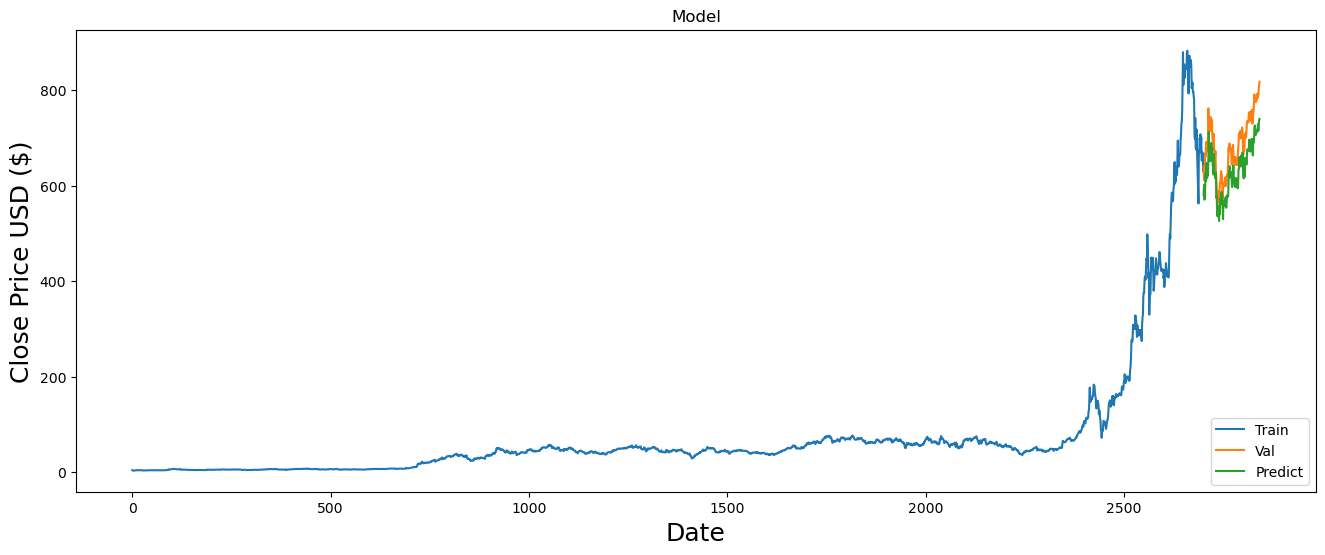

In [28]:
# Plot the data
data = c
train = data[:l]
valid = data[l:]
valid['Predict'] = predict
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predict']])
plt.legend(['Train', 'Val', 'Predict'], loc='lower right')
plt.show()

In [29]:
predictions = model.predict(x_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


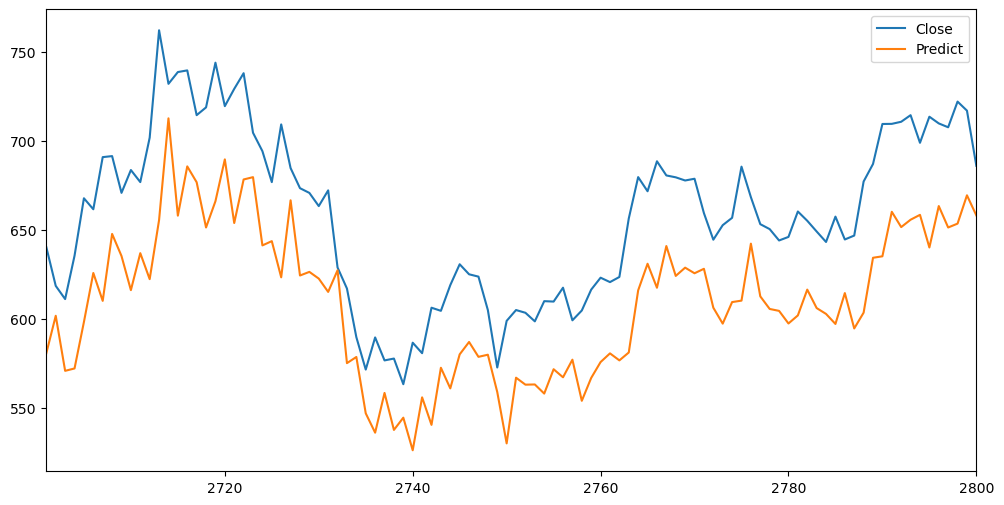

In [30]:
valid[['Close','Predict']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Predicted Close Price (Moving Average): 731.3528299833332


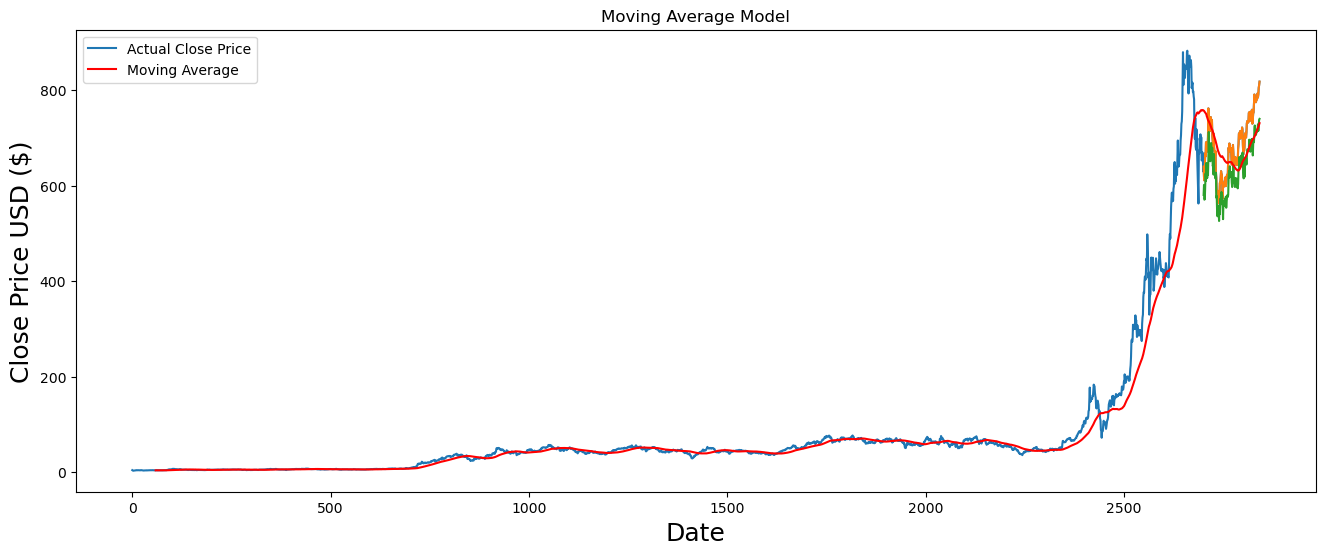

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate moving average
window_size = 60
moving_avg = df['Close'].rolling(window=window_size).mean()

# Get the last value of the moving average for prediction
predicted_values = moving_avg.iloc[-1]

# Print the predicted value
print("Predicted Close Price (Moving Average):", predicted_values)

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Moving Average Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df['Close'], label='Actual Close Price')
plt.plot(valid[['Close', 'Predict']])
plt.plot(moving_avg, label='Moving Average', color='red')
plt.legend()
plt.show()


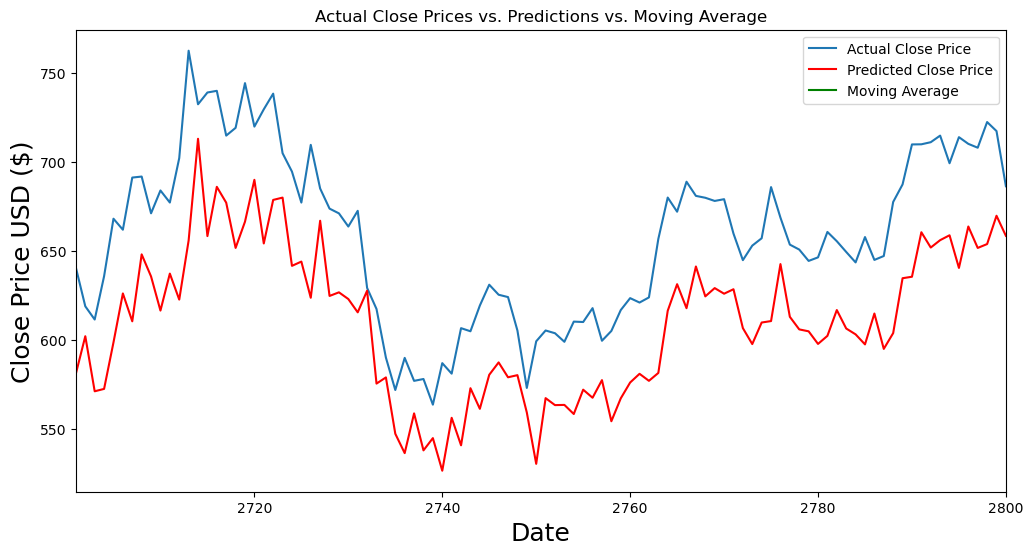

In [32]:
# Plot actual 'Close' prices, predictions, and moving average
plt.figure(figsize=(12,6))
plt.plot(valid['Close'].iloc[:100], label='Actual Close Price')
plt.plot(valid['Predict'].iloc[:100], label='Predicted Close Price', color='red')
plt.plot(predicted_values, label='Moving Average', color='g')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.title('Actual Close Prices vs. Predictions vs. Moving Average')
plt.legend()
plt.xlim(valid.index[:100].min(), valid.index[:100].max())  # Set x-axis limits
plt.show()